## Installing Dependencies

In [1]:
! pip install numpy pandas matplotlib

## Loading the data

In [2]:
import pandas as pd

trips=pd.read_csv("fhvhv_tripdata_2025-07.csv")

zones=pd.read_csv("taxi_zones_toysample_TableToExcel_csv.csv")
#extract zones
selected_zones_ids=zones["LocationID"].tolist()

print(selected_zones_ids)



[25, 33, 45, 65, 66, 87, 88, 209]


## Filtering trips based on start and end location so they only occure within selected zone ids: 

In [3]:
#exrtact trips within zones
filtered_trips=trips[trips["pulocationid"].isin(selected_zones_ids) & trips["dolocationid"].isin(selected_zones_ids)]

In [4]:
print("Original trip count:", len(trips))
print("Filtered trip count:", len(filtered_trips))
filtered_trips[["pulocationid", "dolocationid"]].head()

#save filtered trips

filtered_trips.to_csv("filtered_fhvhv_trips.csv", index=False)


Original trip count: 10783920
Filtered trip count: 39852


## Adding noise on start and end location of trips

In [5]:
import pandas as pd
import numpy as np

# Load data
trips = pd.read_csv("filtered_fhvhv_trips.csv")
zones = pd.read_csv("taxi_zones_toysample_TableToExcel_csv.csv")

# Ensure types align
trips["pulocationid"] = trips["pulocationid"].astype(int)
trips["dolocationid"] = trips["dolocationid"].astype(int)
zones["LocationID"] = zones["LocationID"].astype(int)

# Build centroid lookup
centroids = zones.set_index("LocationID")[["centroid_x", "centroid_y"]].to_dict("index")

# Reproducible noise
rng = np.random.default_rng(42)

# --- choose a jitter scale (feet) ---
# Manhattan block ≈ 250–900 ft; 300–600 ft keeps points “near” the center.
DEFAULT_SIGMA_FT = 500.0  # std dev of Gaussian noise in feet

def jitter_xy(loc_id, sigma_ft=DEFAULT_SIGMA_FT):
    cx = centroids[loc_id]["centroid_x"]
    cy = centroids[loc_id]["centroid_y"]
    # Isotropic Gaussian jitter
    jx = rng.normal(0.0, sigma_ft)
    jy = rng.normal(0.0, sigma_ft)
    return cx + jx, cy + jy

# Apply to trips
pu_xy = trips["pulocationid"].map(lambda z: jitter_xy(int(z)))
do_xy = trips["dolocationid"].map(lambda z: jitter_xy(int(z)))

trips["pu_x"], trips["pu_y"] = zip(*pu_xy)
trips["do_x"], trips["do_y"] = zip(*do_xy)

# Save
trips.to_csv("filtered_fhvhv_trips_with_jitter.csv", index=False)
print("Saved with jittered coordinates.")


Saved with jittered coordinates.


## Filtering the data by time i.e choossing from July 1st to July 8th and then pick from 12-14 hrs trips

In [6]:
import pandas as pd
from datetime import date

# --- load ---
df = pd.read_csv("filtered_fhvhv_trips_with_jitter.csv")

col = "request_datetime"  # <- adjust if your column name differs
# Clean common whitespace issues
df[col] = df[col].astype(str).str.strip()

# --- robust parse: try general parser; if it fails badly, try dayfirst=True ---
dt = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
if dt.notna().sum() == 0:
    dt = pd.to_datetime(df[col], errors="coerce", dayfirst=True, infer_datetime_format=True)

df[col] = dt
print("Parsed datetimes:", df[col].notna().sum(), "rows")
print("NaT (failed to parse):", df[col].isna().sum())


# --- filter: dates Jul 1..Jul 8 inclusive ---
d = df[col].dt.date
mask_date = (d >= date(2025, 7, 1)) & (d <= date(2025, 7, 8))
df_week = df.loc[mask_date].copy()
print("Rows in Jul 1–8 window:", len(df_week))

# --- filter: time between 12:00 and 14:00 (12 <= hour < 14) ---
h = df_week[col].dt.hour
mask_time = (h >= 18) & (h < 20)
df_2h = df_week.loc[mask_time].copy()
print("Rows in 12:00–14:00:", len(df_2h))

# Optional: show a few to confirm
print(df_2h[[col]].head(10))

# --- save ---
out_path = "fhvhv_trips_reqtime_18to20_July1to8_2025.csv"
df_2h.to_csv(out_path, index=False)
print("Saved:", out_path)


Parsed datetimes: 39852 rows
NaT (failed to parse): 0
Rows in Jul 1–8 window: 17005
Rows in 12:00–14:00: 2722
        request_datetime
1544 2025-07-01 18:11:01
1545 2025-07-01 18:27:43
1546 2025-07-01 18:51:46
1547 2025-07-01 18:13:30
1548 2025-07-01 18:47:21
1550 2025-07-01 18:46:13
1551 2025-07-01 18:23:52
1552 2025-07-01 18:02:13
1553 2025-07-01 18:34:48
1554 2025-07-01 18:45:40
Saved: fhvhv_trips_reqtime_18to20_July1to8_2025.csv


C:\Users\lukelo\AppData\Local\Temp\ipykernel_31576\3747853204.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)


## calculate average demand per each zone 

In [7]:
import pandas as pd

# ---- 1. Load your filtered trip data ----
df = pd.read_csv("fhvhv_trips_reqtime_18to20_July1to8_2025.csv")

# ---- 2. Parse datetime and extract fields ----
col = "request_datetime"
df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
df = df.dropna(subset=[col])   # remove any rows that failed parsing

df["date"] = df[col].dt.date
df["hour"] = df[col].dt.hour
df["minute"] = df[col].dt.minute

# ---- 3. Create 15-min time-bin labels ----
# floor each timestamp to the nearest 15 minutes
df["time_bin_start"] = df[col].dt.floor("15min")
df["time_bin_label"] = df["time_bin_start"].dt.strftime("%H:%M")

# ---- 4. Group by zone + time_bin + date ----
grouped = (
    df.groupby(["pulocationid", "time_bin_label", "date"])
      .size()
      .reset_index(name="requests")
)

# ---- 5. Average across days for each zone×time_bin ----
phi_table = (
    grouped.groupby(["pulocationid", "time_bin_label"])["requests"]
    .mean()
    .reset_index()
    .rename(columns={"requests": "avg_requests"})
    .sort_values(["pulocationid", "time_bin_label"])
)

# ---- 6. Save φ table to CSV ----
out_path = "phi_avg_demand_per_zone_15min.csv"
phi_table.to_csv(out_path, index=False)
print(f"Saved: {out_path}")
print(phi_table.head(12))


C:\Users\lukelo\AppData\Local\Temp\ipykernel_31576\2321933619.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)


Saved: phi_avg_demand_per_zone_15min.csv
    pulocationid time_bin_label  avg_requests
0             25          18:00      6.625000
1             25          18:15      6.285714
2             25          18:30      8.875000
3             25          18:45      7.625000
4             25          19:00      6.875000
5             25          19:15      6.625000
6             25          19:30      6.250000
7             25          19:45      9.285714
8             33          18:00      6.625000
9             33          18:15      8.750000
10            33          18:30      8.000000
11            33          18:45      7.750000


## distribution of trips per minute

C:\Users\lukelo\AppData\Local\Temp\ipykernel_31576\832360280.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["request_datetime"] = pd.to_datetime(df["request_datetime"], errors="coerce", infer_datetime_format=True)


Average trips per minute (July 1–8 2025 | 18–20 h):
   minute_of_day  trip_count time_label
0           1080    3.125000      18:00
1           1081    3.571429      18:01
2           1082    3.000000      18:02
3           1083    3.285714      18:03
4           1084    3.000000      18:04
5           1085    3.375000      18:05
6           1086    3.142857      18:06
7           1087    2.000000      18:07
8           1088    3.250000      18:08
9           1089    2.714286      18:09
Overall mean trips/minute: 3.04


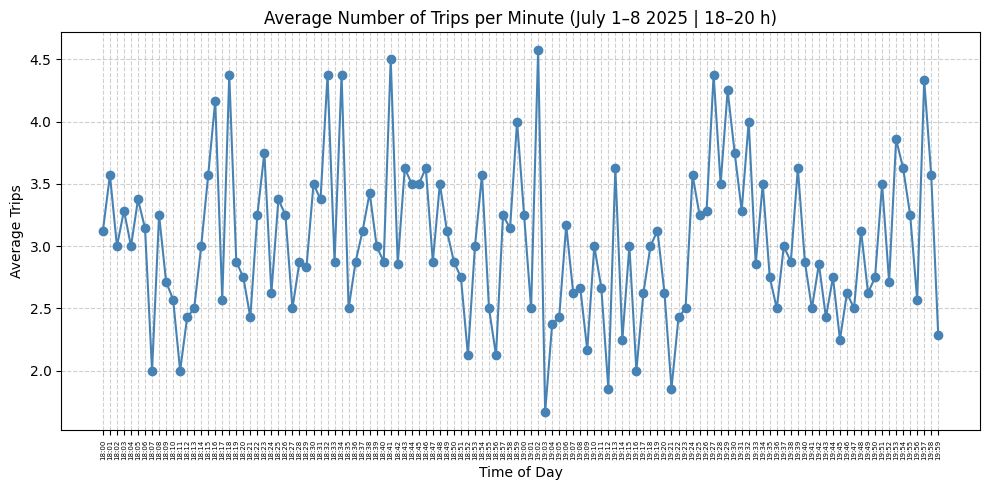

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- 1. Load filtered trips (July 1–8, 12–14) ----
df = pd.read_csv("fhvhv_trips_reqtime_18to20_July1to8_2025.csv")

# ---- 2. Parse datetime ----
df["request_datetime"] = pd.to_datetime(df["request_datetime"], errors="coerce", infer_datetime_format=True)
df = df.dropna(subset=["request_datetime"])

# ---- 3. Create a 'minute of day' field (e.g., 12:00 -> 720, 12:01 -> 721) ----
df["minute_of_day"] = df["request_datetime"].dt.hour * 60 + df["request_datetime"].dt.minute

# ---- 4. Group by date × minute ----
grouped = (
    df.groupby([df["request_datetime"].dt.date, "minute_of_day"])
      .size()
      .reset_index(name="trip_count")
)

# ---- 5. Average across all dates ----
avg_per_min = (
    grouped.groupby("minute_of_day")["trip_count"]
    .mean()
    .reset_index()
)

# ---- 6. Add a readable time label ----
avg_per_min["time_label"] = pd.to_datetime(avg_per_min["minute_of_day"], unit="m").dt.strftime("%H:%M")

# ---- 7. Print summary ----
print("Average trips per minute (July 1–8 2025 | 18–20 h):")
print(avg_per_min.head(10))
print(f"Overall mean trips/minute: {avg_per_min['trip_count'].mean():.2f}")

# ---- 8. Plot ----
plt.figure(figsize=(10, 5))
plt.plot(avg_per_min["time_label"], avg_per_min["trip_count"], marker='o', color="steelblue")
plt.title("Average Number of Trips per Minute (July 1–8 2025 | 18–20 h)")
plt.xlabel("Time of Day")
plt.ylabel("Average Trips")
plt.xticks(rotation=90, size=5)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## Main Loop

In [9]:
# main_loop_inputs_minimal.py
# Build model inputs per minute (c1, c2, c3, phi, gamma, impact)
# Assumes trips are already filtered to your zones + time window.

import numpy as np
import pandas as pd
import math

# --------------------------
# Config (adjust paths)
# --------------------------
REQS_CSV   = "fhvhv_trips_reqtime_18to20_July1to8_2025.csv"               # already filtered trips
ZONES_CSV  = "taxi_zones_toysample_TableToExcel_csv.csv" # has LocationID, centroid_x, centroid_y
PHI_CSV    = "phi_avg_demand_per_zone_15min.csv"         # cols: PULocationID, time_bin_label (HH:MM), avg_requests
FLEET_SIZE = 16
REBAL_ONLY_MATCH_REQ = True   # rebalancing vehicles cannot choose zone columns in c3
SEED = 42
BIG_M = 1e9

rng = np.random.default_rng(SEED)

# --------------------------
# Load trips (already filtered)
# Required cols: request_datetime, pickup_datetime, dropoff_datetime,
#                pulocationid, dolocationid, pu_x, pu_y, do_x, do_y
# --------------------------
df = pd.read_csv(REQS_CSV)
df["request_datetime"]  = pd.to_datetime(df["request_datetime"],  errors="coerce")
df["pickup_datetime"]   = pd.to_datetime(df["pickup_datetime"],   errors="coerce")
df["dropoff_datetime"]  = pd.to_datetime(df["dropoff_datetime"],  errors="coerce")

# normalize column name references
cols = {c.lower(): c for c in df.columns}
PU_ID, DO_ID = cols["pulocationid"], cols["dolocationid"]
PU_X, PU_Y   = cols["pu_x"], cols["pu_y"]
DO_X, DO_Y   = cols["do_x"], cols["do_y"]

# sort & minute bins (for batching)
df = df.sort_values("request_datetime").reset_index(drop=True)
df["minute_bin"] = df["request_datetime"].dt.floor("min")

# compute real wait + trip durations; sanitize minimal issues
df["wait_sec"] = (df["pickup_datetime"]  - df["request_datetime"]).dt.total_seconds()
df["trip_sec"] = (df["dropoff_datetime"] - df["pickup_datetime"]).dt.total_seconds()

if df["wait_sec"].notna().sum():
    df.loc[(df["wait_sec"].isna()) | (df["wait_sec"] < 0), "wait_sec"] = df["wait_sec"].median()
else:
    df["wait_sec"] = 0.0

if df["trip_sec"].notna().sum():
    med_trip = max(60.0, df["trip_sec"].median())
    df.loc[(df["trip_sec"].isna()) | (df["trip_sec"] <= 0), "trip_sec"] = med_trip
else:
    df["trip_sec"] = 600.0

# --------------------------
# Zones (use as-is)
# --------------------------
zones = (
    pd.read_csv(ZONES_CSV)
      [["LocationID", "centroid_x", "centroid_y"]]
      .drop_duplicates()
      .rename(columns={"LocationID": "zone"})
)
zones["zone"] = zones["zone"].astype(int)
zones = zones.sort_values("zone").reset_index(drop=True)

zone_ids     = zones["zone"].tolist()
Z            = len(zone_ids)
zone_to_idx  = {z: i for i, z in enumerate(zone_ids)}
zones_mat    = zones.set_index("zone").loc[zone_ids, ["centroid_x", "centroid_y"]].to_numpy(float)

# --------------------------
# φ (avg demand per zone × 15-min bin) — already computed
# --------------------------
phi_tbl = pd.read_csv(PHI_CSV).rename(columns={"pulocationid": "zone"})
phi_tbl["zone"] = phi_tbl["zone"].astype(int)

def fifteen_bin_label(ts):
    return pd.to_datetime(ts).floor("15min").strftime("%H:%M")

def phi_vector(tstamp):
    lbl = fifteen_bin_label(tstamp)
    s = phi_tbl.loc[phi_tbl["time_bin_label"] == lbl].set_index("zone")["avg_requests"]
    return np.array([float(s.get(z, 0.0)) for z in zone_ids], dtype=float)

# --------------------------
# Initialize fleet evenly (centroid jitter only for uniqueness)
# --------------------------
per_zone = [FLEET_SIZE // Z] * Z
for i in range(FLEET_SIZE % Z):
    per_zone[i] += 1

vehicles = []
vid = 0
for zid, n in zip(zone_ids, per_zone):
    cx, cy = zones_mat[zone_to_idx[zid]]
    for _ in range(n):
        vehicles.append(dict(
            id=vid,
            x=cx + rng.normal(0, 20.0),
            y=cy + rng.normal(0, 20.0),
            zone=zid,
            state="idle",   # idle | rebalancing | enroute | ontrip
        ))
        vid += 1
vehicles = pd.DataFrame(vehicles)
print(vehicles.head())

# --------------------------
# Main loop: per-minute batches → build inputs
# --------------------------
unique_minutes = df["minute_bin"].dropna().sort_values().unique()
epochs = []
Tprime_sec = 15 * 60.0

# --------------------------
# Quick sanity check before main loop. 
# --------------------------
# print("\n=== SAMPLE: Trips Data ===")
# print(df.head(5))
# print(f"Total trips: {len(df)} | Unique minute bins: {df['minute_bin'].nunique()} | Unique zones: {df[PU_ID].nunique()} pickup, {df[DO_ID].nunique()} dropoff")
# print("Trip columns:", list(df.columns))

# print("\n=== SAMPLE: Zones Table ===")
# print(zones.head(5))
# print(f"Total zones loaded: {len(zones)} | Zone IDs: {zone_ids}")

# print("\n=== SAMPLE: phi_avg_demand_per_zone_15min ===")
# print(phi_tbl.head(5))
# print(f"Total φ entries: {len(phi_tbl)} | Unique zones in φ: {phi_tbl['zone'].nunique()} | Unique time bins: {phi_tbl['time_bin_label'].nunique()}")

# print("\n=== SAMPLE: Initial Vehicles ===")
# print(vehicles.head(16))
# print(f"Total vehicles initialized: {len(vehicles)} across {Z} zones")
# print("\n✅ Sanity check complete. If all looks consistent (nonempty, correct IDs, reasonable coordinates), proceed to main loop.\n")

for t in unique_minutes:
    Rt = df.loc[df["minute_bin"] == t].copy()
    R  = len(Rt)

    # vehicle sets (no motion here; you can change states later if you wish)
    idx_idle  = vehicles.index[vehicles["state"] == "idle"].to_list()
    idx_rebal = vehicles.index[vehicles["state"] == "rebalancing"].to_list()
    VI, VB    = len(idx_idle), len(idx_rebal)

    # --- c1: distance btn idle vehicles → requests (Euclidean) ---
    # ---Only compute if you have at least one idle vehicle and at least one request in the current batch (R = len(Rt)).
    if VI > 0 and R > 0:
        v_xy = vehicles.loc[idx_idle, ["x", "y"]].to_numpy(float)
        r_xy = Rt[[PU_X, PU_Y]].to_numpy(float)
        diffs = v_xy[:, None, :] - r_xy[None, :, :]
        c1 = np.sqrt((diffs ** 2).sum(axis=2))  # (|V_I|, |R|)
    else:
        c1 = np.zeros((VI, R), dtype=float)

    # --- c2: distance between idle vehicles → zone centroids ---
    # ---Only compute if you have at least one idle vehicle.
    if VI > 0:
        v_xy = vehicles.loc[idx_idle, ["x", "y"]].to_numpy(float)
        diffs = v_xy[:, None, :] - zones_mat[None, :, :]
        c2 = np.sqrt((diffs ** 2).sum(axis=2))  # (|V_I|, |Z|)
    else:
        c2 = np.zeros((VI, Z), dtype=float)

    # --- c3: distance between matcing vehicle with choice (idle ∪ rebalancing) → (requests ∪ zones) ---
    # --- Build the full candidate vehicle set (idle + rebalancing) for the integrated problem.
    Vehicles_idx = idx_idle + idx_rebal
    Vehicles = len(Vehicles_idx)
    J = R + Z
    if Vehicles > 0:
        v_xy = vehicles.loc[Vehicles_idx, ["x", "y"]].to_numpy(float)
        c3 = np.zeros((Vehicles, J), dtype=float)

        # to requests
        if R > 0:
            r_xy = Rt[[PU_X, PU_Y]].to_numpy(float)
            diffr = v_xy[:, None, :] - r_xy[None, :, :]
            c3[:, :R] = np.sqrt((diffr ** 2).sum(axis=2))

        # to zones
        diffz = v_xy[:, None, :] - zones_mat[None, :, :]
        c3[:, R:] = np.sqrt((diffz ** 2).sum(axis=2))

        # optional: rebalancing vehicles cannot choose zone columns
        # --- Policy toggle: if REBAL_ONLY_MATCH_REQ is True, then rebalancing vehicles are forbidden from choosing zone columns.
        # --- Technically, you “forbid” by assigning a very large cost (BIG_M) to their zone-choice columns.
        if REBAL_ONLY_MATCH_REQ and VB > 0:
            reb_rows = [Vehicles_idx.index(i) for i in idx_rebal]
            c3[np.ix_(reb_rows, list(range(R, R + Z)))] = BIG_M
    else:
        c3 = np.zeros((0, J), dtype=float)

    # --- φ for this epoch ---
    phi = phi_vector(pd.to_datetime(t))   # shape (Z,)

    # --- γ: conservative (current idle vehicles per zone) ---
    gamma = np.zeros(Z, dtype=float)
    for i in idx_idle:
        gamma[zone_to_idx[vehicles.at[i, "zone"]]] += 1.0

    # --- impact: (|V*|, |R|+|Z|, |Z|)
    # requests: departure -1 at current zone; arrival credit uses real durations m_j = wait_sec + trip_sec
    # zones:    departure -1 at current zone; no arrival credit (no time model here)
    impact = np.zeros((Vehicles, J, Z), dtype=float)
    if Vehicles > 0:
        v_cur_zone_ids = [vehicles.at[i, "zone"] for i in Vehicles_idx]
        v_cur_idx      = np.array([zone_to_idx[z] for z in v_cur_zone_ids], dtype=int)

        # requests impact
        if R > 0:
            do_zone_idx = Rt[DO_ID].map(zone_to_idx).to_numpy(int)
            m_j = (Rt["wait_sec"].to_numpy(float) + Rt["trip_sec"].to_numpy(float))  # seconds

            for jj in range(R):
                # departure loss at current zone
                #if any of the vehicles picks request 𝑗𝑗, it leaves its current zone immediately.
                impact[np.arange(Vehicles), jj, v_cur_idx] += -1.0
                # arrival credit if completes within horizon
                # if the request for vehicle 𝑣 v would complete within the 15-min horizon
                # # we credit a fraction of a vehicle back to the destination zone.
                frac = max(0.0, (Tprime_sec - m_j[jj]) / Tprime_sec)
                if m_j[jj] > Tprime_sec:
                    frac = 0.0
                impact[np.arange(Vehicles), jj, do_zone_idx[jj]] += frac

        # zone choices (rebalance): only departure penalty
        for jz in range(Z):
            col = R + jz
            impact[np.arange(Vehicles), col, v_cur_idx] += -1.0

    # --- store epoch bundle ---
    epochs.append(dict(
        t=pd.to_datetime(t),
        request_batch=Rt.copy(),
        vehicles_snapshot=vehicles.copy(),
        idx_idle=idx_idle,
        idx_rebalancing=idx_rebal,
        c1=c1, c2=c2, c3=c3,
        phi=phi, gamma=gamma,
        impact=impact,
        zone_ids=zone_ids,
    ))

    print(f"[{t}] R={R} | |VI|={len(idx_idle)} | c1{c1.shape} c2{c2.shape} c3{c3.shape}")




   id              x              y  zone state
0   0  988107.315642  189050.779618    25  idle
1   1  988116.230324  189090.390594    25  idle
2   2  985528.118696  192748.448910    33  idle
3   3  985569.696208  192768.167648    33  idle
4   4  984762.133377  198827.575321    45  idle
[2025-07-01 18:00:00] R=1 | |VI|=16 | c1(16, 1) c2(16, 8) c3(16, 9)
[2025-07-01 18:01:00] R=5 | |VI|=16 | c1(16, 5) c2(16, 8) c3(16, 13)
[2025-07-01 18:02:00] R=4 | |VI|=16 | c1(16, 4) c2(16, 8) c3(16, 12)
[2025-07-01 18:03:00] R=3 | |VI|=16 | c1(16, 3) c2(16, 8) c3(16, 11)
[2025-07-01 18:04:00] R=6 | |VI|=16 | c1(16, 6) c2(16, 8) c3(16, 14)
[2025-07-01 18:05:00] R=4 | |VI|=16 | c1(16, 4) c2(16, 8) c3(16, 12)
[2025-07-01 18:06:00] R=4 | |VI|=16 | c1(16, 4) c2(16, 8) c3(16, 12)
[2025-07-01 18:07:00] R=1 | |VI|=16 | c1(16, 1) c2(16, 8) c3(16, 9)
[2025-07-01 18:08:00] R=4 | |VI|=16 | c1(16, 4) c2(16, 8) c3(16, 12)
[2025-07-01 18:09:00] R=3 | |VI|=16 | c1(16, 3) c2(16, 8) c3(16, 11)
[2025-07-01 18:10:00] R=

In [10]:
we are doing everything in minutes but then i see the trip time is set in seconds?wouldn't that be a problem? 

SyntaxError: unterminated string literal (detected at line 1) (2688976526.py, line 1)